In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import re
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import nltk
import matplotlib.pyplot as plt

In [60]:
import tmdbsimple as tmdb
# get api key from tmdb_config.json
import json
with open('../tmdb_config.json') as f:
    config = json.load(f)
tmdb.API_KEY = config['TMDB_API_KEY']

In [61]:
mock_movie_titles =[
    "Iron Man",
    # 'The Dark Knight',
    "Ocean's Eleven",
    "finding nemo",
    "The Lord of the Rings: The Fellowship of the Ring",
    "Die Hard",
    "Marvel's The Avengers",
    "The Godfather",
    "The Shawshank Redemption",
    "Inside",
    "The Matrix",
    "Nightmare on Elm Street",
    "The Silence of the Lambs",
    "The Sixth Sense",
    "The Usual Suspects",
    "The Departed",
    "The Prestige",
    "The Dark Knight Rises",
    "The Jungle Book",
    "The Lion King",
    "Monsters Inc.",
    "Toy Story",
    "A Simple Favor",
    "Mama Mia",
    "The Notebook",
    "The Fault in Our Stars",
    "The Hunger Games",
    "My Big Fat Greek Wedding",
    "The Hangover",
    "The Proposal",
    "Bird Box",
    "Birdman",
    "The Shape of Water"
]

In [62]:
# get movie ids from movie titles
movie_ids = []
for title in mock_movie_titles:
    response = tmdb.Search().movie(query=title)
    movie_ids.append(response['results'][0]['id'])

In [63]:
# Find the director of a movie
def find_director(movie_id):
    movie_credits = tmdb.Movies(movie_id).credits()
    for crew_member in movie_credits['crew']:
        if crew_member['job'] == 'Director':
            return crew_member['name']
    return None

print(find_director(movie_ids[0]))

Jon Favreau


In [64]:
# get movie details, we only need the overview, genres, release year, and director
movie_details = []
for movie in movie_ids[:]:
    
    details = tmdb.Movies(movie).info()
    
    # get genres, join them into a string
    genres = " ".join([genre['name'] for genre in details['genres']])

    # get synopsis, do some preprocessing
    overview = details['overview']
    overview = overview.lower()
    # use regex to remove all non-alphanumeric characters
    overview = re.sub(r'[^a-zA-Z0-9\s]', '', overview)

    # get release year
    release_year = int(details['release_date'].split("-")[0])
    
    # get director
    director = find_director(movie)

    # go to imbd for more information
    imdb_id = details['imdb_id']

    # append to movie_details
    movie_details.append({
        'title': details['title'],
        'overview': overview,
        'genres': genres,
        'release_year': release_year,
        'director': director
    })

# convert to pandas dataframe
pandas_movie_details = pd.DataFrame(movie_details)

In [65]:
# nltk.download('punkt')
# nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_column(df, column_name):
    # tokenize the text
    df[column_name] = df[column_name].apply(lambda x: word_tokenize(x))
    # remove stop words
    df[column_name] = df[column_name].apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    # stem the words
    df[column_name] = df[column_name].apply(lambda x: [stemmer.stem(word) for word in x])
    # join the words back into a string
    df[column_name] = df[column_name].apply(lambda x: " ".join(x))

# # print before
# print(pandas_movie_details['overview'][0])

stem_column(pandas_movie_details, 'overview')
stem_column(pandas_movie_details, 'genres')

# # print after
# print(pandas_movie_details['overview'][0])

In [66]:
# create a stemmer
stemmer = PorterStemmer()

# # stem the overview
stemmed_overview = []
for overview in pandas_movie_details['overview']:
    stemmed_overview.append(" ".join([stemmer.stem(word) for word in overview.split(" ")]))

# # stem the genres
stemmed_genres = []
for genres in pandas_movie_details['genres']:
    stemmed_genres.append(" ".join([stemmer.stem(word) for word in genres.split(" ")]))

# # update the dataframe with the stemmed text
# pandas_movie_details['overview'] = stemmed_overview
# pandas_movie_details['genres'] = stemmed_genres


In [67]:
# #post stemming
# print(pandas_movie_details['overview'][0])

['love', 'young', 'man', 'unexpect', 'romanc', 'comedi', 'world', 'children', 'action', 'stori', 'mysteri', 'thriller', 'year', 'life', 'famili', 'adventur', 'crime', 'scienc', 'fiction', 'drama']


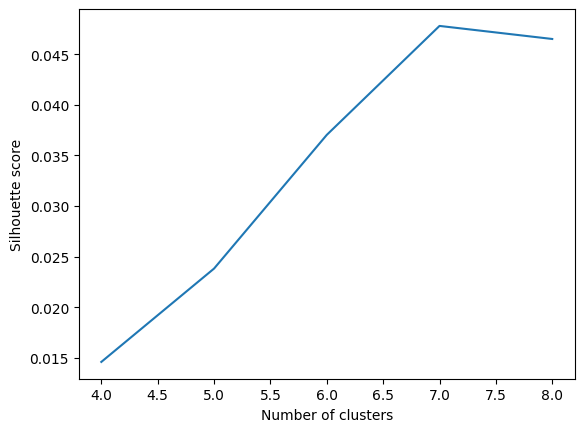

Cluster:  4
Iron Man 2
The Avengers
Inside Out
The Matrix Resurrections
The Hunger Games: Mockingjay - Part 1
The Proposal

Cluster:  1
Ocean's Eleven
The Godfather
The Shawshank Redemption
The Silence of the Lambs
The Usual Suspects
The Dark Knight Rises

Cluster:  5
Finding Nemo
The Lord of the Rings: The Fellowship of the Ring
The Sixth Sense
The Jungle Book
Toy Story
Mama Mia - Nur keine Panik

Cluster:  0
Die Hard
The Notebook
My Big Fat Greek Wedding
The Shape of Water

Cluster:  3
A Nightmare on Elm Street
The Lion King
Monsters, Inc.
Bird Box

Cluster:  2
The Departed
The Fault in Our Stars
The Hangover
Birdman or (The Unexpected Virtue of Ignorance)

Cluster:  6
The Prestige
A Simple Favor



In [99]:
# prepare the dataframe for clustering
df = pandas_movie_details.drop(columns=['title'])

# create a tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# fit the vectorizer to the entire dataframe
vectors = vectorizer.fit_transform(df['genres'] + " " + df['overview'])
# vectors = vectorizer.fit_transform(df['overview'])

# update the dataframe with the vectorized data
df_vectors = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

# # print the number of columns
# print(len(df_vectors.columns))

# reduce dimensionality using PCA
num_components = 20
svd = TruncatedSVD(n_components=num_components)
df_vectors_reduced = svd.fit_transform(df_vectors)

# print the top 10 features after dimensionality reduction
top_c = svd.components_.argsort()[:, -num_components:]
print([vectorizer.get_feature_names_out()[i] for i in top_c[0]])

from sklearn.metrics import silhouette_score

# Compute the silhouette score for different values of n_clusters
scores = []
kmeans_models = {}
for n_clusters in range(4,9):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    clusters = kmeans.fit_predict(df_vectors_reduced)
    score = silhouette_score(df_vectors_reduced, clusters)
    scores.append(score)
    kmeans_models[score] = kmeans

# Plot the silhouette scores
plt.plot(range(4, 9), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# save n_clusters that maximizes the silhouette score
best_score = max(scores)
best_model = kmeans_models[best_score]

# add the labels, to the original dataframe
pandas_movie_details['cluster'] = best_model.labels_

# print each cluster and the movies in it
for cluster in pandas_movie_details['cluster'].unique():
    print("Cluster: ", cluster)
    titles = pandas_movie_details[pandas_movie_details['cluster'] == cluster]['title']
    for title in titles:
        print(title)
    print()